## Analiza cen bitcoina w celu przewidzenia trendu 
**Wykonana została analiza trendu dla ceny bitcoina na podstawie danych w latach 2023-2024**

### 1. Zebranie danych
Zbieranie danych dotyczących cen bitcoina, wolumenu handlu oraz liczby aktywnych numerów portfeli danego dnia, w okresie od 2023-01-01 do dnia dzisiejszego. Do pozyskania danych użyto platformy Santiment, wartości dotyczące cen oraz wolumenu są cenami w dolarach.

Wykonanie potrzebnych importów

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr
%matplotlib inline

Pobranie odpowiednich danych:
1. Ceny bitcoina w danym dniu (price_usd)
2. Wartości wolumenu handlu (volume_usd)
3. Liczby aktywnych adresów portfeli (daily_active_addresses)

Odczytanie danych

In [2317]:
data = pd.read_json('bitcoin_data_extended.json')

### 2. Analiza danych

#### Przetwarzanie wstępne

In [2318]:
data.set_index('date', inplace=True)

Statystyki opisowe danych

In [2319]:
data.describe()

,price,volume,daily_active_addresses
count,500.000000,5.000000e+02,5.000000e+02
mean,36502.922867,2.230608e+10,9.232130e+05
std,14641.556960,1.296501e+10,1.077966e+05
min,16625.080551,5.330878e+09,5.068360e+05
25%,26612.200207,1.330781e+10,8.635395e+05
50%,29655.685469,1.917592e+10,9.295200e+05
75%,43036.922631,2.710762e+10,9.920420e+05
max,73079.373379,1.028029e+11,1.238270e+06


Sprawdzenie czy wśród danych są dane brakujące

In [2320]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2023-01-01 to 2024-05-14
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   500 non-null    float64
 1   volume                  500 non-null    int64  
 2   daily_active_addresses  500 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 15.6 KB


In [2321]:
def show_missing_values():
    nulls = data.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()

,Number,Percentage


**Wniosek**: W zbiorze danych nie ma danych brakujących, możliwa jest dalsza analiza

##### Przesunięcie wolumenu oraz liczby aktywnych adresów w przód

In [2322]:
data['volume'] = data['volume'].shift(1)
data['daily_active_addresses'] = data['daily_active_addresses'].shift(1)
data = data.dropna()

Zostanie wykonane usunięcie danych odstających zgodnie z regułą IQR

In [2323]:
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data = remove_outliers(data, 'price')
data = remove_outliers(data, 'volume')
data = remove_outliers(data, 'daily_active_addresses')
data.describe() #ponowne wyświetlenie statystyk opisowych po usunięciu danych odstających

,price,volume,daily_active_addresses
count,440.000000,4.400000e+02,4.400000e+02
mean,33074.453283,1.962944e+10,9.294818e+05
std,10940.147260,8.911973e+09,9.648073e+04
min,16679.857080,5.330878e+09,6.741520e+05
25%,26350.279147,1.280448e+10,8.656555e+05
50%,29162.818013,1.775849e+10,9.321730e+05
75%,39484.092166,2.523251e+10,9.939365e+05
max,67234.097576,4.493046e+10,1.156847e+06


W celu usprawnienia dalszej analizy, wykonana zostanie normalizacja.

In [2324]:
scaler = StandardScaler()
data[['price', 'volume', 'daily_active_addresses']] = scaler.fit_transform(data[['price', 'volume', 'daily_active_addresses']])

data.describe()

,price,volume,daily_active_addresses
count,4.400000e+02,4.400000e+02,4.400000e+02
mean,-5.167584e-16,1.614870e-17,4.037175e-16
std,1.001138e+00,1.001138e+00,1.001138e+00
min,-1.500278e+00,-1.606248e+00,-2.649445e+00
25%,-6.153325e-01,-7.666910e-01,-6.622972e-01
50%,-3.579557e-01,-2.101765e-01,2.792576e-02
75%,5.865492e-01,6.294279e-01,6.688185e-01
max,3.125966e+00,2.842223e+00,2.359269e+00


In [2325]:
data.head()

,price,volume,daily_active_addresses
date,,,
2023-01-02,-1.499489,-1.166622,-2.203377
2023-01-03,-1.500278,-0.846080,-0.828608
2023-01-04,-1.483496,-0.643279,0.549026
2023-01-05,-1.485922,-0.135669,-0.077168
2023-01-06,-1.475376,-0.666905,0.055652


Dane zostają przekształcone tak by średnia była bliska 0, a odchylenie standardowe 1

#### Analiza eksploracyjna

##### Wykresy liniowe

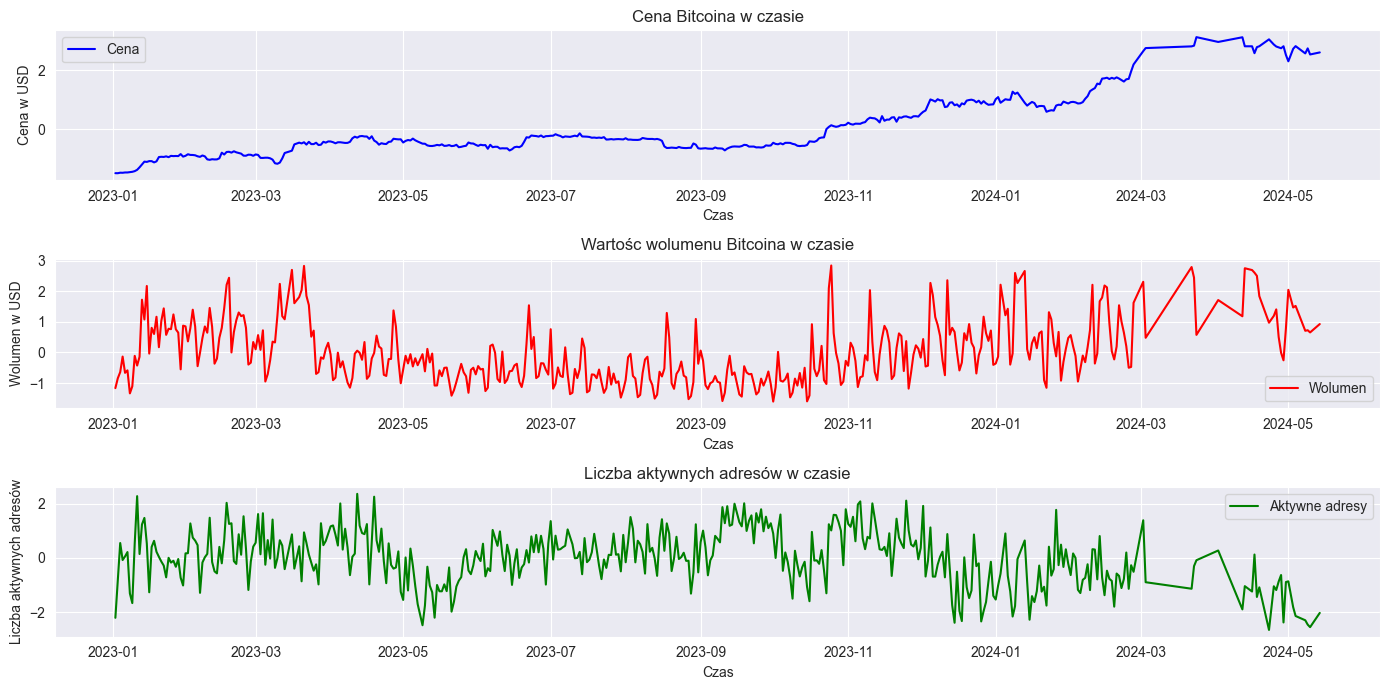

In [2326]:
plt.figure(figsize=(14,7))

plt.subplot(3, 1, 1)
plt.plot(data.index, data['price'], label='Cena', color='blue')
plt.title('Cena Bitcoina w czasie')
plt.xlabel('Czas')
plt.ylabel('Cena w USD')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data.index, data['volume'], label='Wolumen', color='red')
plt.title('Wartośc wolumenu Bitcoina w czasie')
plt.xlabel('Czas')
plt.ylabel('Wolumen w USD')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data.index, data['daily_active_addresses'], label='Aktywne adresy', color='green')
plt.title('Liczba aktywnych adresów w czasie')
plt.xlabel('Czas')
plt.ylabel('Liczba aktywnych adresów')
plt.legend()


plt.tight_layout()
plt.show()

##### Histogramy

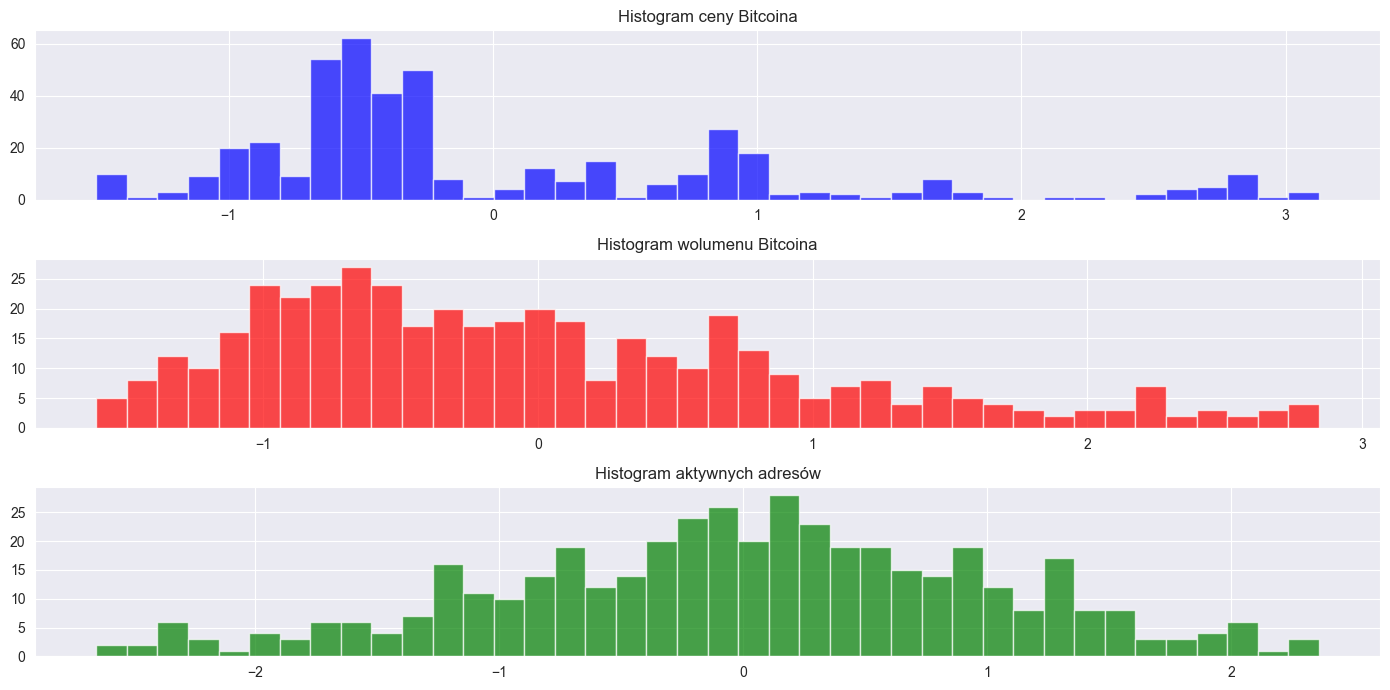

In [2327]:
plt.figure(figsize=(14,7))

plt.subplot(3, 1, 1)
plt.hist(data['price'], bins=40, alpha=0.7, color='blue')
plt.title('Histogram ceny Bitcoina')

plt.subplot(3, 1, 2)
plt.hist(data['volume'], bins=40, alpha=0.7, color='red')
plt.title('Histogram wolumenu Bitcoina')

plt.subplot(3, 1, 3)
plt.hist(data['daily_active_addresses'], bins=40, alpha=0.7, color='green')
plt.title('Histogram aktywnych adresów')


plt.tight_layout()
plt.show()

##### Macierz korelacji

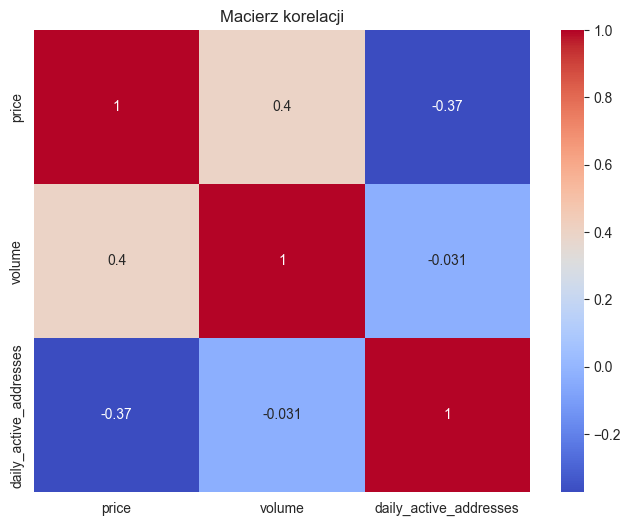

In [2328]:
correlation_matrix = data.corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Macierz korelacji')
plt.savefig('correlation_matrix.png')
plt.show()
plt.close()

##### Wykresy rozrzutu

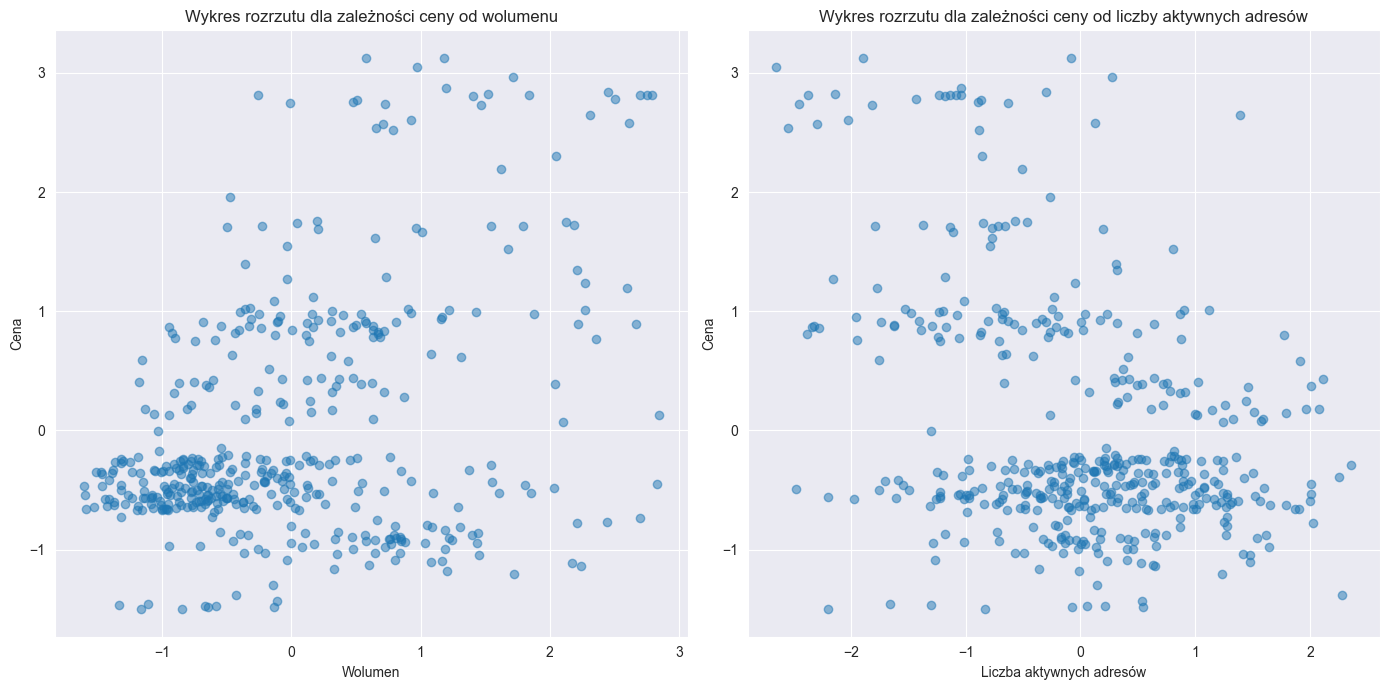

In [2329]:
plt.figure(figsize=(14,7))

plt.subplot(1, 2, 1)
plt.scatter(data['volume'], data['price'], alpha=0.5)
plt.title('Wykres rozrzutu dla zależności ceny od wolumenu')
plt.xlabel('Wolumen')
plt.ylabel('Cena')

plt.subplot(1, 2, 2)
plt.scatter(data['daily_active_addresses'], data['price'], alpha=0.5)
plt.title('Wykres rozrzutu dla zależności ceny od liczby aktywnych adresów')
plt.xlabel('Liczba aktywnych adresów')
plt.ylabel('Cena')

plt.tight_layout()
plt.savefig('wykresy_rozrzutu.png')
plt.show()
plt.close()

##### Wykresy par

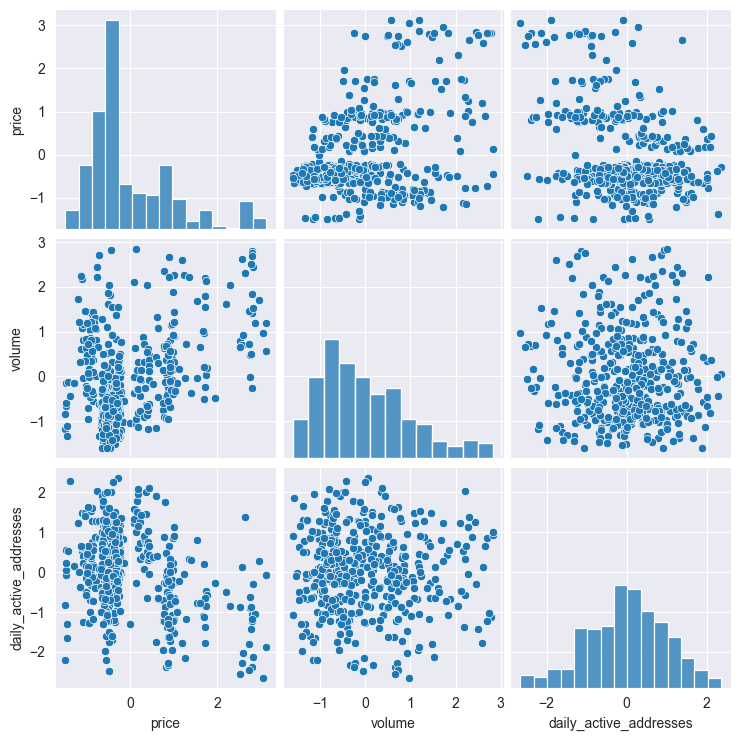

In [2330]:
sns.pairplot(data)
plt.savefig('Wykresy par')
plt.show()

##### Uzupełnienie o cechcę 'trend'

In [2331]:
data['price_diff'] = data['price'].diff()
data['trend'] = data['price_diff'].apply(lambda x: 1 if x > 0 else 0)
data = data.dropna() #usunięcie powstałych pustych rekordów

print(data.describe())
print(data.tail())
print(data.head())
pd.DataFrame.to_csv(data.head(), 'after_processing_head.csv')
pd.DataFrame.to_csv(data.describe(), 'after_processing_desc.csv')

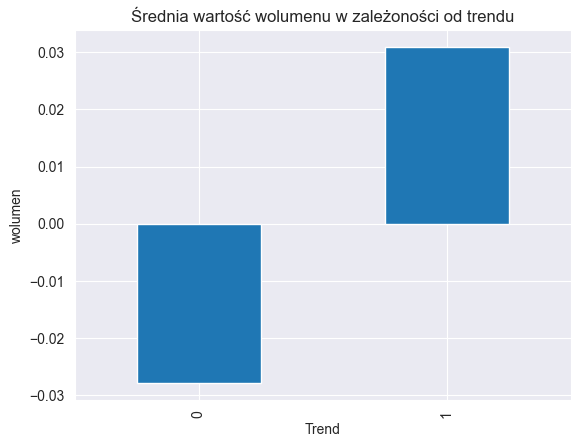

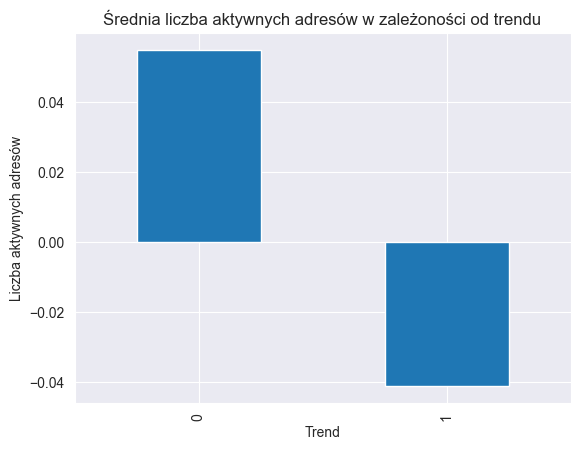

          price    volume  daily_active_addresses  price_diff
trend                                                        
0     -0.077355 -0.027854                0.054895   -0.045163
1      0.078164  0.030894               -0.041138    0.059803


In [2332]:
trend_means = data.groupby('trend').mean()

trend_means['volume'].plot(kind='bar')
plt.xlabel('Trend')
plt.ylabel('wolumen')
plt.title('Średnia wartość wolumenu w zależoności od trendu')
plt.show()

trend_means['daily_active_addresses'].plot(kind='bar')
plt.xlabel('Trend')
plt.ylabel('Liczba aktywnych adresów')
plt.title('Średnia liczba aktywnych adresów w zależoności od trendu')
plt.show()

print(trend_means)

### 3. Eksperymenty

#### Podział danych na dane testowe i tereningowe

In [2333]:
x = data[['volume', 'daily_active_addresses']]
y = data['trend']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### Model pierwszy: regresja logistyczna

              precision    recall  f1-score   support

           0       0.38      0.20      0.26        41
           1       0.51      0.72      0.60        47

    accuracy                           0.48        88
   macro avg       0.44      0.46      0.43        88
weighted avg       0.45      0.48      0.44        88


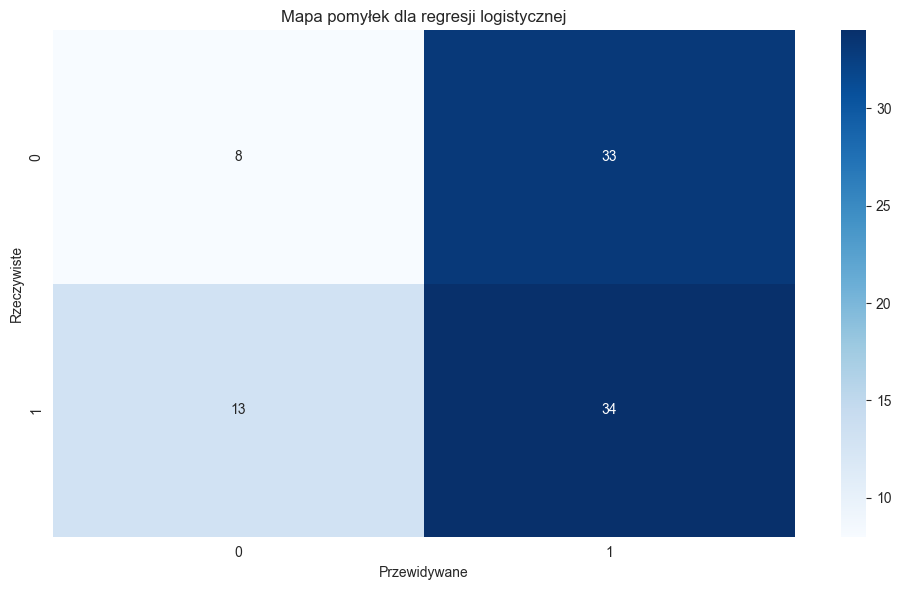

In [2334]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)
y_pred_lr = lr_model.predict(x_test)

print(classification_report(y_test, y_pred_lr))

rep = classification_report(y_test, y_pred_lr, output_dict=True)
df = pd.DataFrame(rep).transpose()
df.to_csv('lr_raport.csv')

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Mapa pomyłek dla regresji logistycznej')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.tight_layout()
plt.savefig('confusion_matrix_lr.png')
plt.show()
plt.close()

#### Model drugi: Losowy las decyzyjny

              precision    recall  f1-score   support

           0       0.55      0.59      0.56        41
           1       0.61      0.57      0.59        47

    accuracy                           0.58        88
   macro avg       0.58      0.58      0.58        88
weighted avg       0.58      0.58      0.58        88


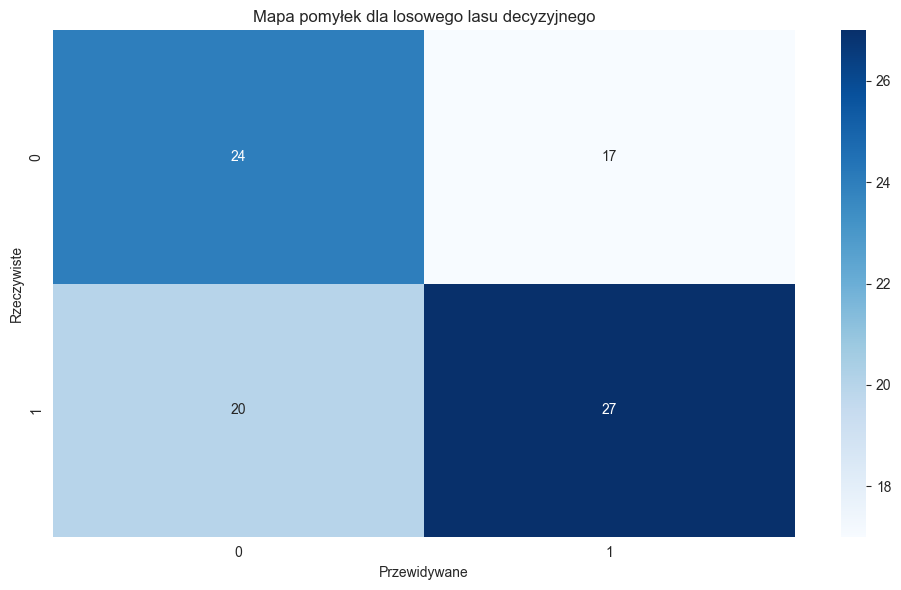

In [2335]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Mapa pomyłek dla losowego lasu decyzyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.tight_layout()
plt.show()
plt.close()

##### Losowy las decyzyjny z doborem parametrów za pomocą grid search

In [2336]:
param_rf = {'n_estimators': [20, 40, 80, 160],
            'max_depth': [None, 1, 10, 20, 30]}

rf_model_grid = GridSearchCV(RandomForestClassifier(), param_rf, refit=True, cv=5)
rf_model_grid.fit(x_train, y_train)
print(rf_model_grid.best_params_)

{'max_depth': 20, 'n_estimators': 160}


              precision    recall  f1-score   support

           0       0.54      0.54      0.54        41
           1       0.60      0.60      0.60        47

    accuracy                           0.57        88
   macro avg       0.57      0.57      0.57        88
weighted avg       0.57      0.57      0.57        88


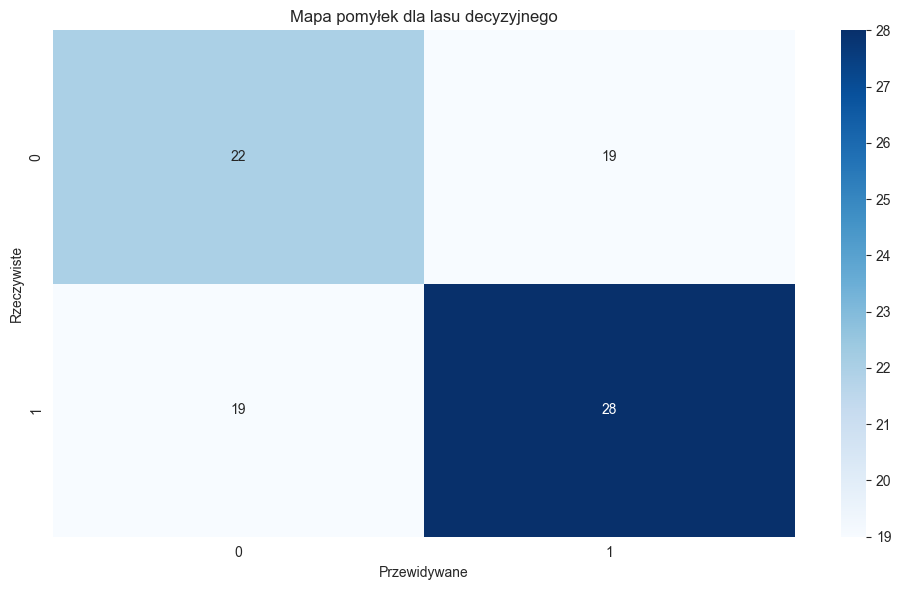

In [2337]:
y_pred_rf_grid = rf_model_grid.predict(x_test)

print(classification_report(y_test, y_pred_rf_grid))

rep = classification_report(y_test, y_pred_rf_grid, output_dict=True)
df = pd.DataFrame(rep).transpose()
df.to_csv('rf_grid_raport.csv')

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_grid), annot=True, fmt='d', cmap='Blues')
plt.title('Mapa pomyłek dla lasu decyzyjnego')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.tight_layout()
plt.savefig('confusion_matrix_rf_grid.png')
plt.show()
plt.close()

   #### Model trzeci: Support Vector Machine

              precision    recall  f1-score   support

           0       0.52      0.34      0.41        41
           1       0.56      0.72      0.63        47

    accuracy                           0.55        88
   macro avg       0.54      0.53      0.52        88
weighted avg       0.54      0.55      0.53        88


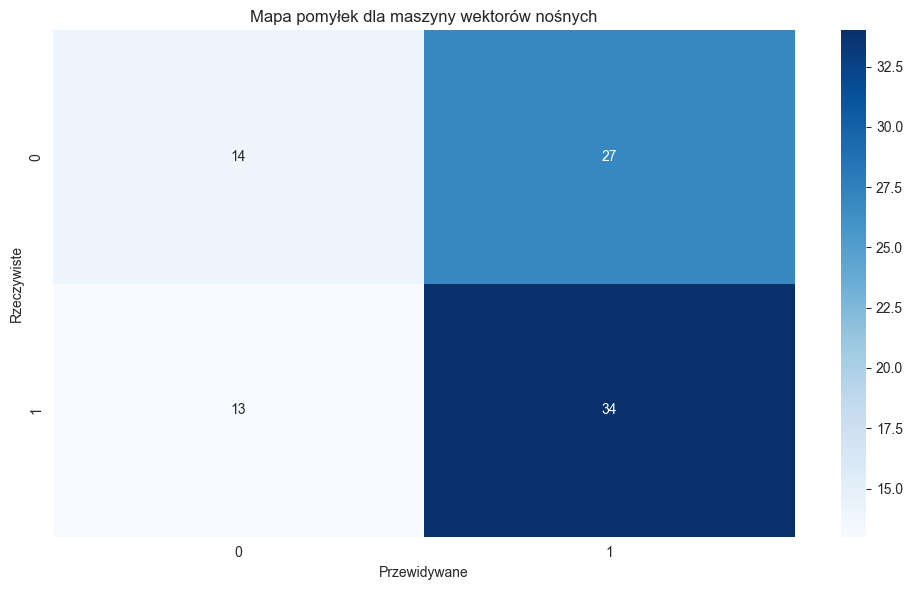

In [2338]:
svm_model = SVC()
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)

print(classification_report(y_test, y_pred_svm))

rep = classification_report(y_test, y_pred_svm, output_dict=True)
df = pd.DataFrame(rep).transpose()
df.to_csv('svm_raport.csv')

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('Mapa pomyłek dla maszyny wektorów nośnych')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.tight_layout()
plt.savefig('confusion_matrix_svm.png')
plt.show()
plt.close()

##### SVM z doborem parametrów za pomocą grid search

In [2339]:
param_svm = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

svm_model_grid = GridSearchCV(SVC(), param_svm, refit=True, cv=3)
svm_model_grid.fit(x_train, y_train)
print(svm_model_grid.best_params_)

{'gamma': 0.1}


              precision    recall  f1-score   support

           0       0.43      0.29      0.35        41
           1       0.52      0.66      0.58        47

    accuracy                           0.49        88
   macro avg       0.47      0.48      0.46        88
weighted avg       0.48      0.49      0.47        88


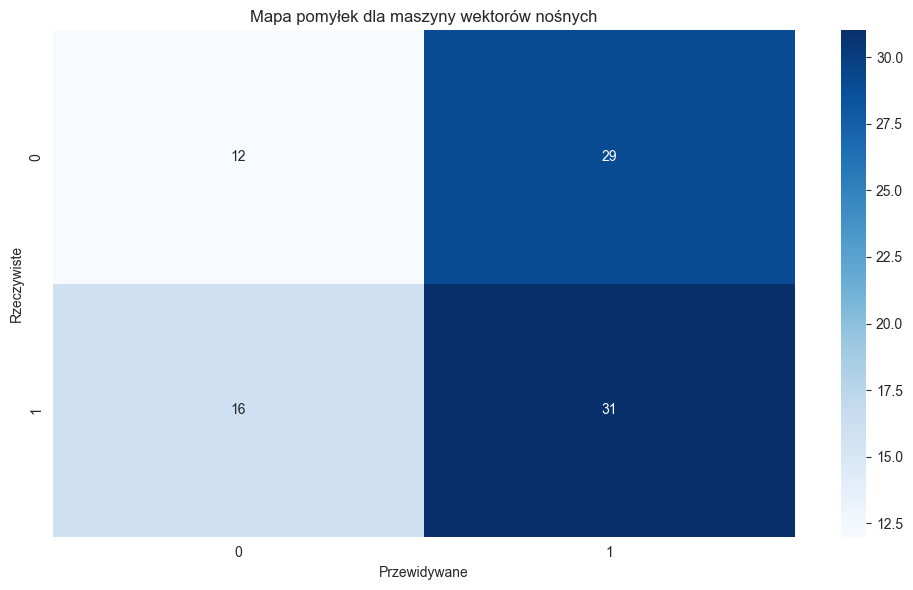

In [2340]:
y_pred_svm_grid = svm_model_grid.predict(x_test)

print(classification_report(y_test, y_pred_svm_grid))

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm_grid), annot=True, fmt='d', cmap='Blues')
plt.title('Mapa pomyłek dla maszyny wektorów nośnych')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.tight_layout()
plt.show()
plt.close()

In [2341]:
lr_scores = cross_val_score(lr_model, x, y, scoring='accuracy')
np.mean(lr_scores)

0.48301985370950895

In [2342]:
rf_scores = cross_val_score(rf_model, x, y, scoring='accuracy')
np.mean(rf_scores)

0.5148119122257053

In [2343]:
rf_scores = cross_val_score(rf_model_grid, x, y, scoring='accuracy')
np.mean(rf_scores)

0.48524033437826547

In [2344]:
svm_scores = cross_val_score(svm_model, x, y, scoring='accuracy')
np.mean(svm_scores)

0.48521421107628004

In [2345]:
svm_scores_grid = cross_val_score(svm_model_grid, x, y, scoring='accuracy')
np.mean(svm_scores_grid)

0.5034221525600836

##### Uzupełnienie o nowe cechy

In [2346]:
data['trend_3d'] = data['price'].rolling(window=3).mean().shift(1)
data['trend_7d'] = data['price'].rolling(window=7).mean().shift(1)
data['trend_14d'] = data['price'].rolling(window=14).mean().shift(1)


In [2347]:
data = data.dropna()

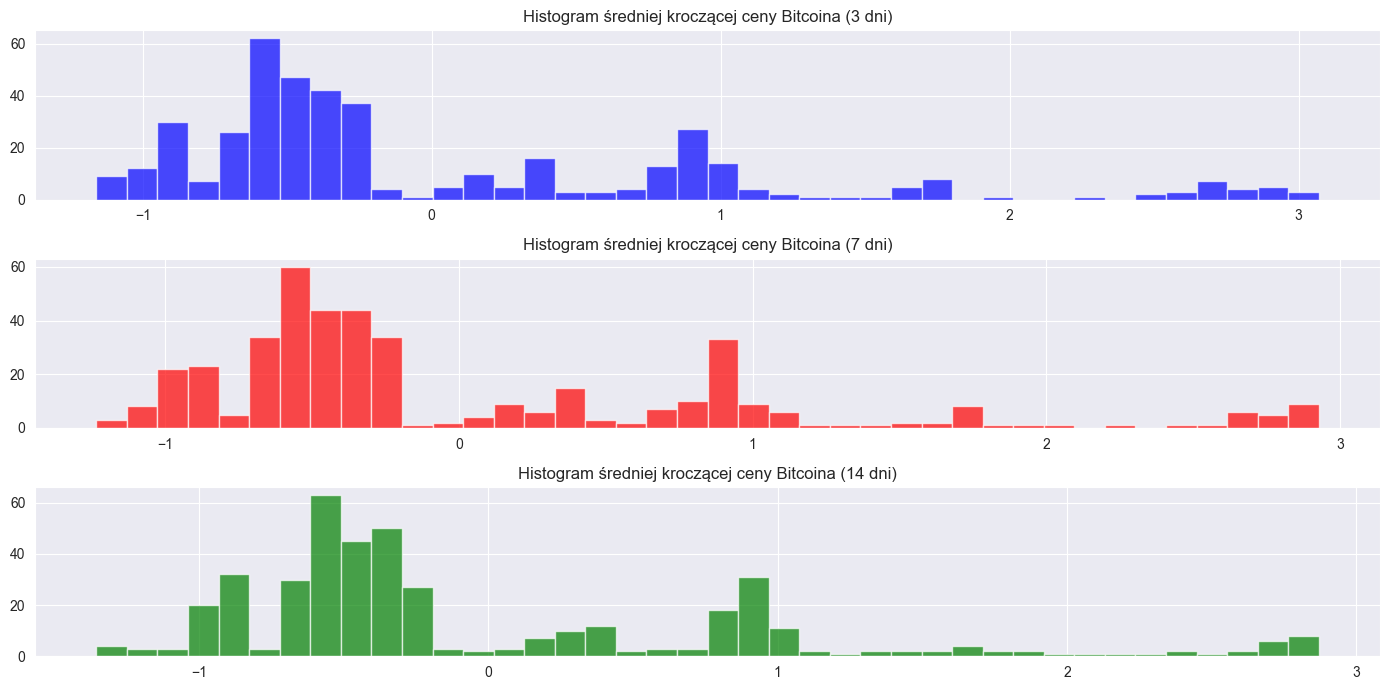

In [2348]:
plt.figure(figsize=(14,7))

plt.subplot(3, 1, 1)
plt.hist(data['trend_3d'], bins=40, alpha=0.7, color='blue')
plt.title('Histogram średniej kroczącej ceny Bitcoina (3 dni)')

plt.subplot(3, 1, 2)
plt.hist(data['trend_7d'], bins=40, alpha=0.7, color='red')
plt.title('Histogram średniej kroczącej ceny Bitcoina (7 dni)')

plt.subplot(3, 1, 3)
plt.hist(data['trend_14d'], bins=40, alpha=0.7, color='green')
plt.title('Histogram średniej kroczącej ceny Bitcoina (14 dni)')


plt.tight_layout()
plt.show()

In [2349]:
data.head()

,price,volume,daily_active_addresses,price_diff,trend,trend_3d,trend_7d,trend_14d
date,,,,,,,,
2023-01-17,-1.090159,0.804671,0.405591,-0.000742,0,-1.104124,-1.233242,-1.354892
2023-01-18,-1.133419,0.603307,0.630171,-0.043261,0,-1.098474,-1.184673,-1.325598
2023-01-19,-1.096997,1.165622,0.227010,0.036422,1,-1.104331,-1.148672,-1.300593
2023-01-20,-0.951517,0.171134,0.041042,0.145480,1,-1.106858,-1.119687,-1.272812
2023-01-21,-0.942268,1.030092,-0.131614,0.009249,1,-1.060644,-1.083495,-1.235394


In [2350]:
corr = pointbiserialr(data['trend_3d'], data['trend'])
print(corr)
corr = pointbiserialr(data['trend_7d'], data['trend'])
print(corr)
corr = pointbiserialr(data['trend_14d'], data['trend'])
print(corr)

SignificanceResult(statistic=0.05450349050180693, pvalue=0.2622272054932753)
SignificanceResult(statistic=0.05557242398580781, pvalue=0.2529703797705174)
SignificanceResult(statistic=0.056847331406390554, pvalue=0.24222959221955287)


#### Stworzenie funkcji pomocniczych

In [2351]:
def train_and_evaluate_model(model, params, x_train, y_train, x_test, y_test):
    grid = GridSearchCV(model, params, cv=10, scoring='accuracy')
    grid.fit(x_train, y_train)
    best_model=grid.best_estimator_
    y_pred = best_model.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    #print(best_model.best_params_)
    return best_model, accuracy, cm, cr

In [2352]:
def print_confusion_matrix(cm, model, suffix='new'):
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Mapa pomyłek - {model}')
    plt.xlabel('Przewidywane')
    plt.ylabel('Rzeczywiste')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model}_{suffix}.png')  
    plt.show()
    plt.close()

In [2353]:
def save_report(cr, model, suffix='new'):
    df = pd.DataFrame(cr).transpose()
    df.to_csv(f'{model}_report_{suffix}.csv')

#### Eksperymenty dla średnich kroczących

In [2354]:
x = data[['trend_3d', 'trend_7d', 'trend_7d']]
y = data['trend']

In [2355]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [2356]:
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

#### Regresja logistyczna

0.4823529411764706
{'0': {'precision': 0.5423728813559322, 'recall': 0.6530612244897959, 'f1-score': 0.5925925925925926, 'support': 49.0}, '1': {'precision': 0.34615384615384615, 'recall': 0.25, 'f1-score': 0.2903225806451613, 'support': 36.0}, 'accuracy': 0.4823529411764706, 'macro avg': {'precision': 0.4442633637548892, 'recall': 0.45153061224489793, 'f1-score': 0.4414575866188769, 'support': 85.0}, 'weighted avg': {'precision': 0.4592683487997546, 'recall': 0.4823529411764706, 'f1-score': 0.46457235223838644, 'support': 85.0}}


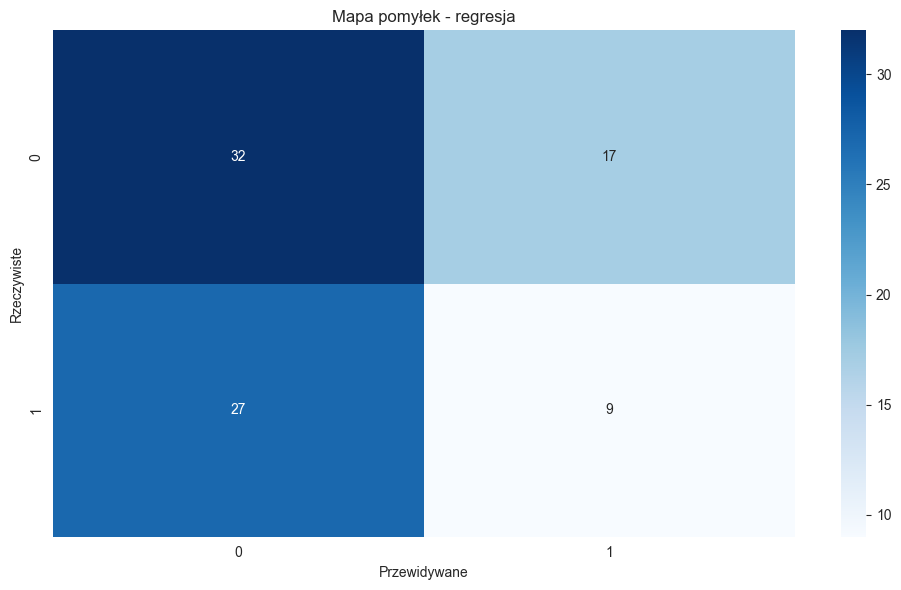

In [2357]:
lr_model = LogisticRegression(max_iter=1000)
lr_params = {}
lr_best_model, lr_accuracy, lr_cm, lr_cr = (
    train_and_evaluate_model(lr_model, lr_params, x_train, y_train, x_test, y_test))
print(lr_accuracy)
print(lr_cr)
save_report(lr_cr, "regresja", "m")
print_confusion_matrix(lr_cm, "regresja", "m")

In [2358]:
lr_scores = cross_val_score(lr_best_model, x, y, scoring='accuracy')
np.mean(lr_scores)

0.5105882352941176

#### Losowy las decyzyjny

0.47058823529411764
{'0': {'precision': 0.5526315789473685, 'recall': 0.42857142857142855, 'f1-score': 0.4827586206896552, 'support': 49.0}, '1': {'precision': 0.40425531914893614, 'recall': 0.5277777777777778, 'f1-score': 0.4578313253012048, 'support': 36.0}, 'accuracy': 0.47058823529411764, 'macro avg': {'precision': 0.4784434490481523, 'recall': 0.47817460317460314, 'f1-score': 0.47029497299543, 'support': 85.0}, 'weighted avg': {'precision': 0.48978986891509124, 'recall': 0.47058823529411764, 'f1-score': 0.4722011779368997, 'support': 85.0}}


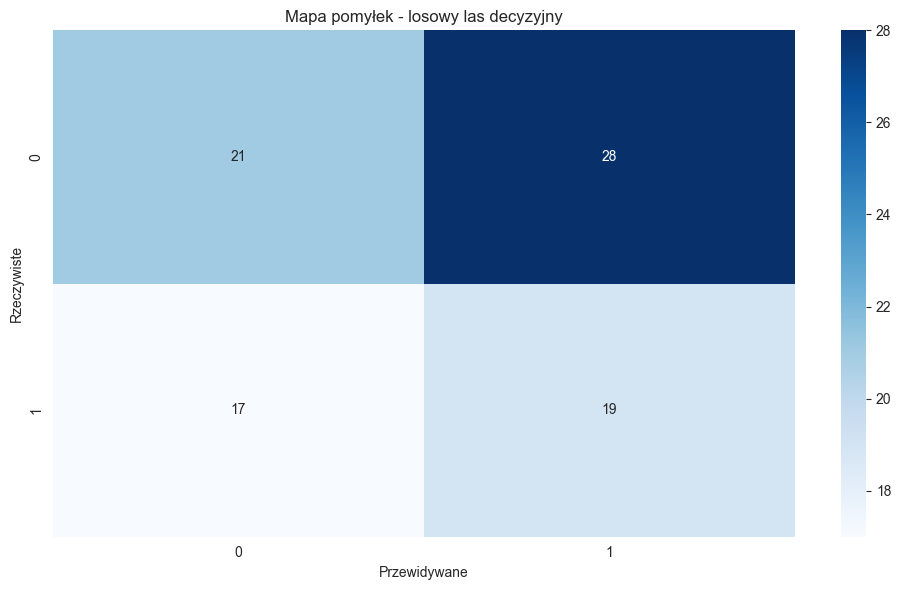

In [2359]:
rf_model = RandomForestClassifier()
rf_params = {}
rf_best_model, rf_accuracy, rf_cm, rf_cr = (
    train_and_evaluate_model(rf_model, rf_params, x_train, y_train, x_test, y_test))
print(rf_accuracy)
print(rf_cr)
print_confusion_matrix(rf_cm, "losowy las decyzyjny", "m")
save_report(rf_cr, "losowy las decyzyjny", "m")

In [2360]:
rf_scores = cross_val_score(rf_best_model, x, y, scoring='accuracy')
np.mean(rf_scores)

0.4023529411764706

#### SVM

0.5294117647058824
{'0': {'precision': 0.5737704918032787, 'recall': 0.7142857142857143, 'f1-score': 0.6363636363636364, 'support': 49.0}, '1': {'precision': 0.4166666666666667, 'recall': 0.2777777777777778, 'f1-score': 0.3333333333333333, 'support': 36.0}, 'accuracy': 0.5294117647058824, 'macro avg': {'precision': 0.4952185792349727, 'recall': 0.49603174603174605, 'f1-score': 0.48484848484848486, 'support': 85.0}, 'weighted avg': {'precision': 0.5072324011571842, 'recall': 0.5294117647058824, 'f1-score': 0.5080213903743316, 'support': 85.0}}


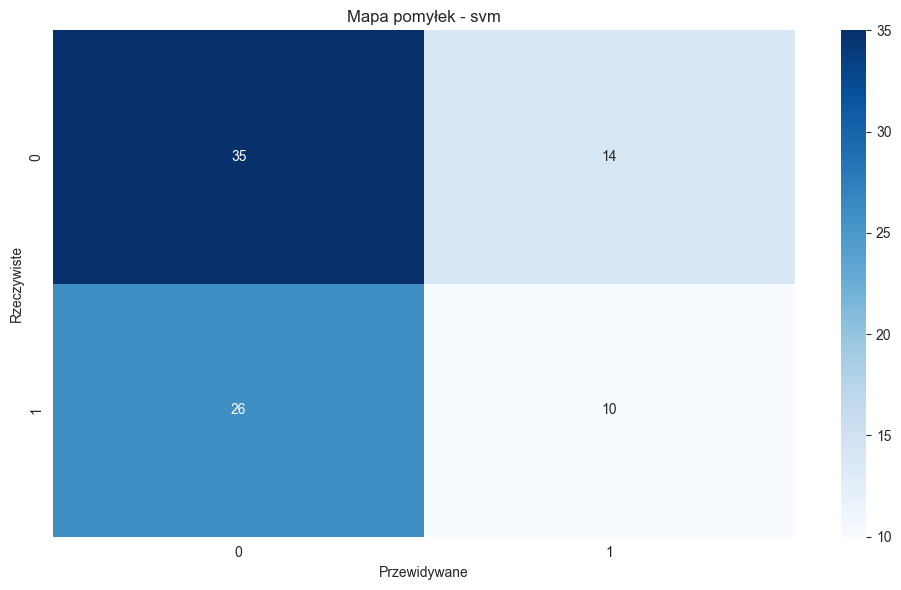

In [2361]:
svm_model = SVC()
param_svm = {'C': [0.1, 1, 10, 100, 1000]}
svm_best_model, svm_accuracy, svm_cm, svm_cr = (
    train_and_evaluate_model(svm_model, param_svm, x_train, y_train, x_test, y_test))
print(svm_accuracy)
print(svm_cr)
print_confusion_matrix(svm_cm, "svm", 'm')
save_report(svm_cr, "svm", 'm')

In [2362]:
svm_scores = cross_val_score(svm_best_model, x, y, scoring='accuracy')
np.mean(svm_scores)

0.39529411764705885

##### Dodanie cechy dotyczącej trendu z poprzedniego dnia

In [2363]:
data['prev_trend'] = data['trend'].shift(1)
data = data.dropna()

In [2364]:
table = pd.crosstab(data['trend'], data['prev_trend'])
chi, p, dof, ex = chi2_contingency(table)
print(chi)
print(p)

1.3811941583485927
0.2398978434433898


In [2365]:
data.tail()

,price,volume,daily_active_addresses,price_diff,trend,trend_3d,trend_7d,trend_14d,prev_trend
date,,,,,,,,,
2024-05-04,2.820171,1.521324,-2.137227,0.091641,1,2.517490,2.671501,2.745513,1.0
2024-05-08,2.572977,0.707863,-2.294328,-0.247193,0,2.617631,2.673350,2.745881,1.0
2024-05-09,2.743552,0.725550,-2.453131,0.170575,1,2.707226,2.644167,2.728620,0.0
2024-05-10,2.536571,0.654235,-2.547827,-0.206982,0,2.712233,2.643498,2.740254,1.0
2024-05-14,2.606177,0.927869,-2.023043,0.069606,1,2.617700,2.603677,2.722492,0.0


### Eksperymenty dla trendu z poprzedniego dnia, wolumenu oraz aktywności

In [2366]:
x = data[['prev_trend','volume', 'daily_active_addresses', 'trend_3d']]
y = data['trend']

In [2367]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

#### Regresja logistyczna

0.4588235294117647
{'0': {'precision': 0.42, 'recall': 0.5526315789473685, 'f1-score': 0.4772727272727273, 'support': 38.0}, '1': {'precision': 0.5142857142857142, 'recall': 0.3829787234042553, 'f1-score': 0.43902439024390244, 'support': 47.0}, 'accuracy': 0.4588235294117647, 'macro avg': {'precision': 0.4671428571428571, 'recall': 0.4678051511758119, 'f1-score': 0.45814855875831484, 'support': 85.0}, 'weighted avg': {'precision': 0.4721344537815126, 'recall': 0.4588235294117647, 'f1-score': 0.45612364679796524, 'support': 85.0}}


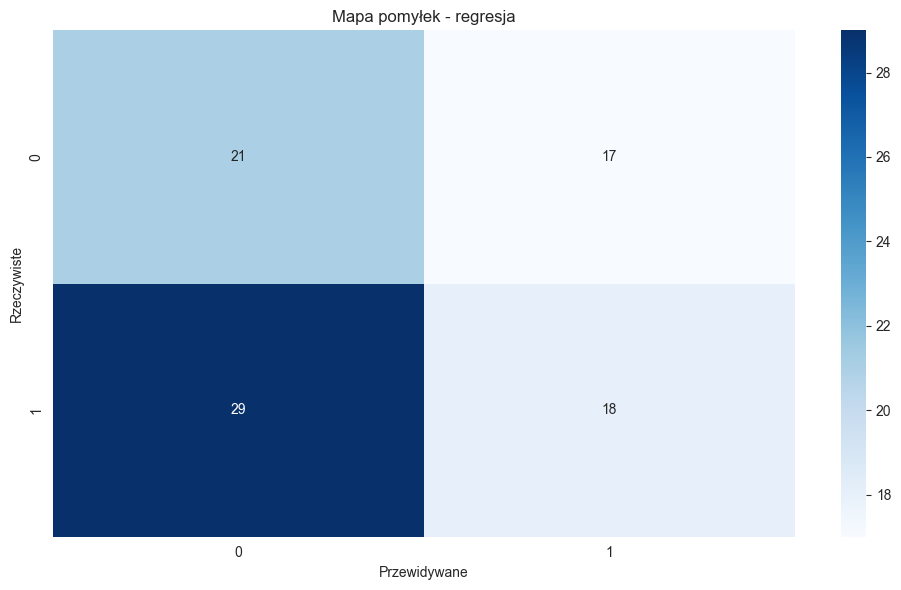

In [2368]:
lr_model = LogisticRegression(max_iter=1000)
lr_params = {}
lr_best_model, lr_accuracy, lr_cm, lr_cr = (
    train_and_evaluate_model(lr_model, lr_params, x_train_resampled, y_train_resampled, x_test, y_test))
print(lr_accuracy)
print(lr_cr)
save_report(lr_cr, "regresja", "prev_trend")
print_confusion_matrix(lr_cm, "regresja", "prev_trend")

In [2369]:
lr_scores = cross_val_score(lr_best_model, x, y, scoring='accuracy')
np.mean(lr_scores)

0.5047338935574229

#### Losowy las decyzyjny

0.5764705882352941
{'0': {'precision': 0.53125, 'recall': 0.4473684210526316, 'f1-score': 0.4857142857142857, 'support': 38.0}, '1': {'precision': 0.6037735849056604, 'recall': 0.6808510638297872, 'f1-score': 0.64, 'support': 47.0}, 'accuracy': 0.5764705882352941, 'macro avg': {'precision': 0.5675117924528301, 'recall': 0.5641097424412094, 'f1-score': 0.5628571428571428, 'support': 85.0}, 'weighted avg': {'precision': 0.5713512763596005, 'recall': 0.5764705882352941, 'f1-score': 0.5710252100840336, 'support': 85.0}}


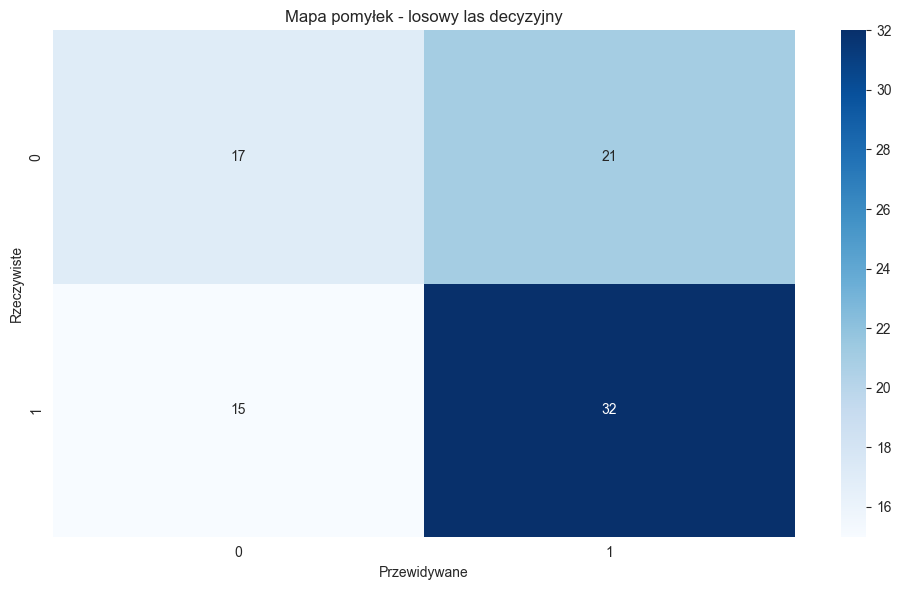

In [2370]:
rf_model = RandomForestClassifier()
rf_params = {}
rf_best_model, rf_accuracy, rf_cm, rf_cr = (
    train_and_evaluate_model(rf_model, rf_params, x_train_resampled, y_train_resampled, x_test, y_test))
print(rf_accuracy)
print(rf_cr)
print_confusion_matrix(rf_cm, "losowy las decyzyjny", "prev_trend")
save_report(rf_cr, "losowy las decyzyjny", "prev_trend")

In [2371]:
rf_scores = cross_val_score(rf_best_model, x, y, scoring='accuracy')
np.mean(rf_scores)

0.4977591036414566

#### SVM

0.5176470588235295
{'0': {'precision': 0.4634146341463415, 'recall': 0.5, 'f1-score': 0.4810126582278481, 'support': 38.0}, '1': {'precision': 0.5681818181818182, 'recall': 0.5319148936170213, 'f1-score': 0.5494505494505495, 'support': 47.0}, 'accuracy': 0.5176470588235295, 'macro avg': {'precision': 0.5157982261640799, 'recall': 0.5159574468085106, 'f1-score': 0.5152316038391989, 'support': 85.0}, 'weighted avg': {'precision': 0.5213447241424286, 'recall': 0.5176470588235295, 'f1-score': 0.5188547863156948, 'support': 85.0}}


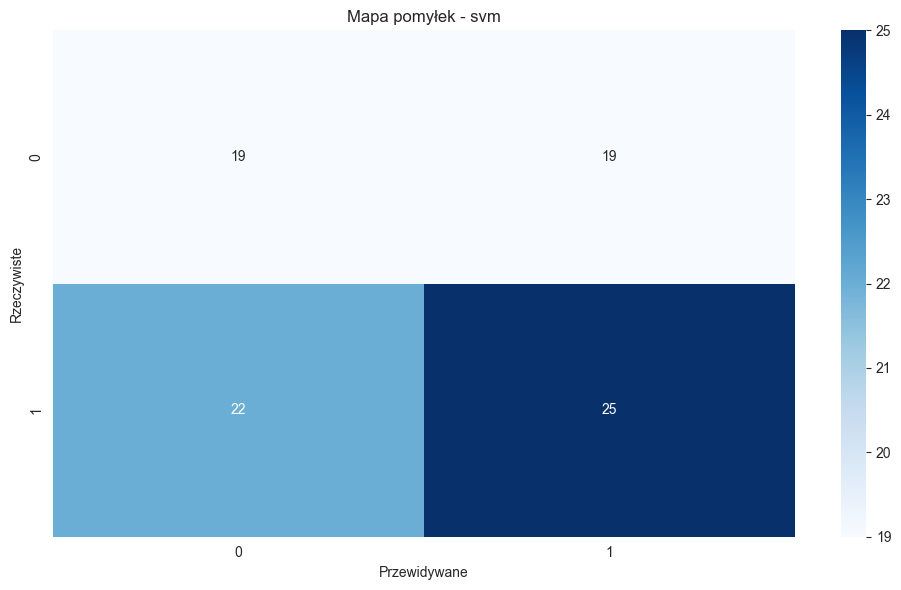

In [2372]:
svm_model = SVC()
param_svm = {'C': [0.1, 1, 10, 100, 1000]}
svm_best_model, svm_accuracy, svm_cm, svm_cr = (
    train_and_evaluate_model(svm_model, param_svm, x_train, y_train, x_test, y_test))
print(svm_accuracy)
print(svm_cr)
print_confusion_matrix(svm_cm, "svm", 'prev_trend')
save_report(svm_cr, "svm", 'prev_trend')

In [2373]:
svm_scores = cross_val_score(svm_best_model, x, y, scoring='accuracy')
np.mean(svm_scores)

0.47411764705882353

### Eksperymenty dla wszystkich cech

In [2374]:
x   = data[['volume', 'daily_active_addresses', 'trend_3d', 'trend_7d', 'trend_7d', 'prev_trend']]
y = data['trend']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

#### Regresja logistyczna

0.4588235294117647
{'0': {'precision': 0.42, 'recall': 0.5526315789473685, 'f1-score': 0.4772727272727273, 'support': 38.0}, '1': {'precision': 0.5142857142857142, 'recall': 0.3829787234042553, 'f1-score': 0.43902439024390244, 'support': 47.0}, 'accuracy': 0.4588235294117647, 'macro avg': {'precision': 0.4671428571428571, 'recall': 0.4678051511758119, 'f1-score': 0.45814855875831484, 'support': 85.0}, 'weighted avg': {'precision': 0.4721344537815126, 'recall': 0.4588235294117647, 'f1-score': 0.45612364679796524, 'support': 85.0}}


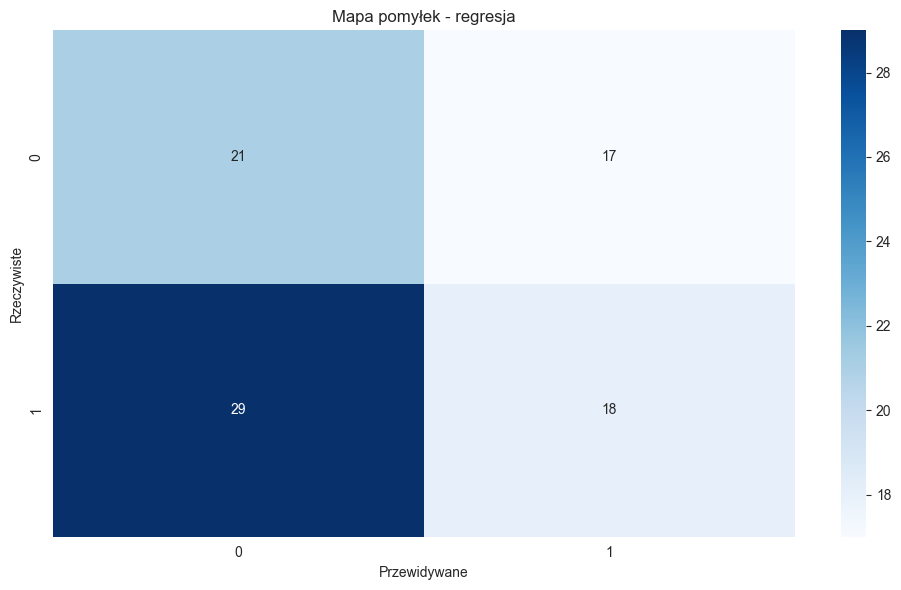

In [2375]:
lr_model = LogisticRegression(max_iter=1000)
lr_params = {}
lr_best_model, lr_accuracy, lr_cm, lr_cr = (
    train_and_evaluate_model(lr_model, lr_params, x_train, y_train, x_test, y_test))
print(lr_accuracy)
print(lr_cr)
save_report(lr_cr, "regresja", "w")
print_confusion_matrix(lr_cm, "regresja", "w")

In [2376]:
lr_scores = cross_val_score(lr_best_model, x, y, scoring='accuracy')
np.mean(lr_scores)

0.5023809523809524

#### Decyzyjny las losowy

0.47058823529411764
{'0': {'precision': 0.41025641025641024, 'recall': 0.42105263157894735, 'f1-score': 0.4155844155844156, 'support': 38.0}, '1': {'precision': 0.5217391304347826, 'recall': 0.5106382978723404, 'f1-score': 0.5161290322580645, 'support': 47.0}, 'accuracy': 0.47058823529411764, 'macro avg': {'precision': 0.4659977703455964, 'recall': 0.46584546472564387, 'f1-score': 0.46585672392124006, 'support': 85.0}, 'weighted avg': {'precision': 0.4718997967079809, 'recall': 0.47058823529411764, 'f1-score': 0.47117967421572743, 'support': 85.0}}


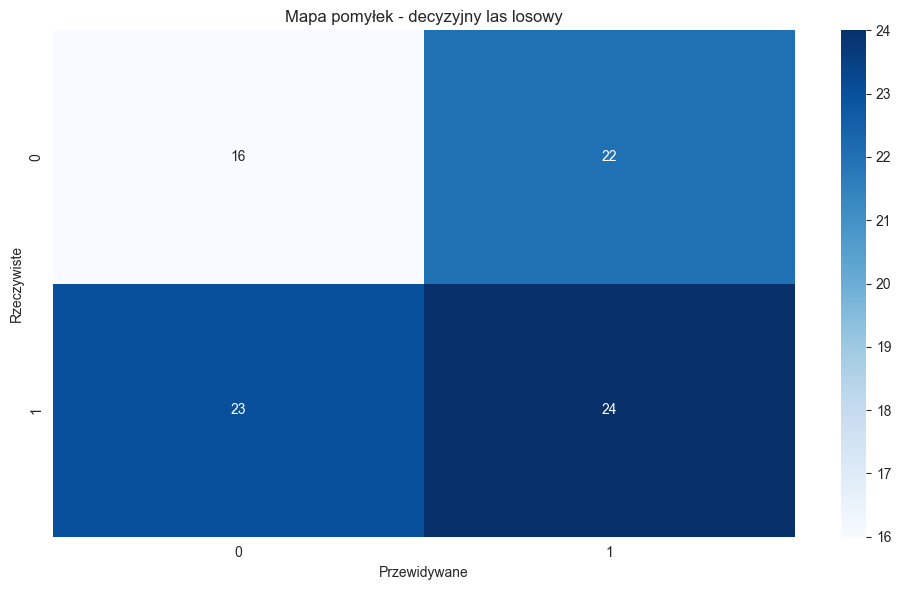

In [2377]:
rf_model = RandomForestClassifier()
rf_params = {}
rf_best_model, rf_accuracy, rf_cm, rf_cr = (
    train_and_evaluate_model(rf_model, rf_params, x_train, y_train, x_test, y_test))
print(rf_accuracy)
print(rf_cr)
print_confusion_matrix(rf_cm, "decyzyjny las losowy", "w")
save_report(rf_cr, "decyzyjny las losowy", "w")

In [2378]:
rf_scores = cross_val_score(rf_best_model, x, y, scoring='accuracy')
np.mean(rf_scores)

0.42705882352941177

#### SVM

0.4588235294117647
{'0': {'precision': 0.43548387096774194, 'recall': 0.7105263157894737, 'f1-score': 0.54, 'support': 38.0}, '1': {'precision': 0.5217391304347826, 'recall': 0.2553191489361702, 'f1-score': 0.34285714285714286, 'support': 47.0}, 'accuracy': 0.4588235294117647, 'macro avg': {'precision': 0.47861150070126224, 'recall': 0.4829227323628219, 'f1-score': 0.44142857142857145, 'support': 85.0}, 'weighted avg': {'precision': 0.4831779556142232, 'recall': 0.4588235294117647, 'f1-score': 0.4309915966386555, 'support': 85.0}}


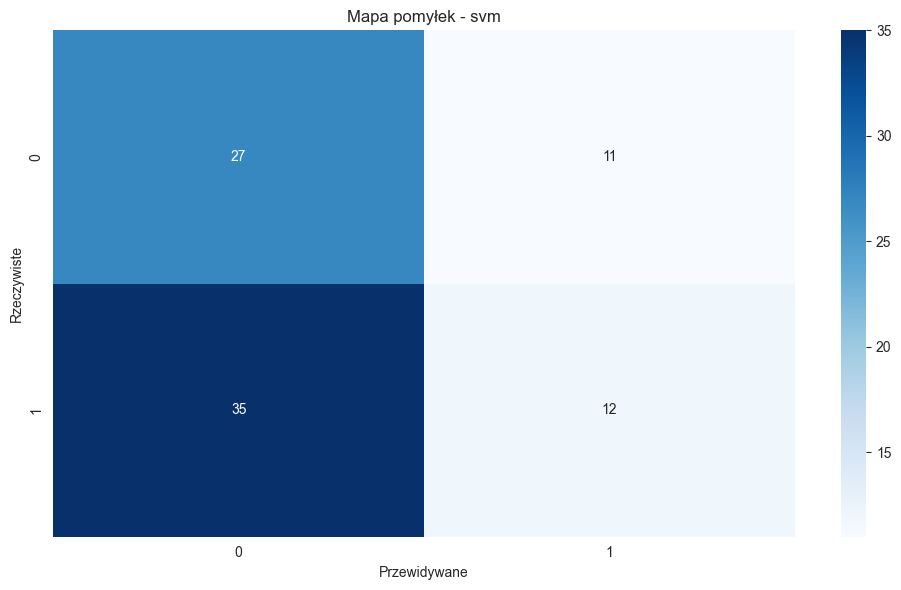

In [2379]:
svm_model = SVC()
param_svm = {}
svm_best_model, svm_accuracy, svm_cm, svm_cr = (
    train_and_evaluate_model(svm_model, param_svm, x_train, y_train, x_test, y_test))
print(svm_accuracy)
print(svm_cr)
print_confusion_matrix(svm_cm, "svm", 'wg')
save_report(svm_cr, "svm", 'wg')

In [2380]:
svm_scores = cross_val_score(svm_best_model, x, y, scoring='accuracy')
np.mean(svm_scores)

0.4764705882352941